In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cp_common import process_price_data as cpc
from cp_scratch import network_fundamentals as cpsn
from cp_scratch import basic_functions as cpsb
%matplotlib inline
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import initializers, regularizers 

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
mean, std, pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest, Xtrain, ytrainOrig, Xtest, ytestOrig = cpc.return_data(andrewEncoding=False)

Loaded BCHARTS/BITFINEXUSD from cache
Loaded BCHARTS/COINBASEUSD from cache


In [10]:
pd_Xtrain.to_csv(header='')

KeyError: 'Date'

In [3]:
ytrain = cpsb.convert_to_one_hot(ytrainOrig, 9, andrewEncoding=False)
ytest = cpsb.convert_to_one_hot(ytestOrig, 9, andrewEncoding=False)

In [4]:
print(Xtrain.shape)
print(ytrainOrig.shape)
print(ytrain.shape)
print()
print(Xtest.shape)
print(ytestOrig.shape)
print(ytest.shape)

(1500, 7)
(1500, 1)
(1500, 9)

(156, 7)
(156, 1)
(156, 9)


In [168]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(7,), kernel_initializer=initializers.he_normal(seed=1), kernel_regularizer=regularizers.l2(0.007)))#10 is the first layer
model.add(BatchNormalization()) 
model.add(Dropout(0.3))

model.add(Dense(8, activation='relu', kernel_initializer=initializers.he_normal(seed=1), kernel_regularizer=regularizers.l2(0.007)))
model.add(BatchNormalization()) 
model.add(Dropout(0.3))

model.add(Dense(7, activation='relu', kernel_initializer=initializers.he_normal(seed=1), kernel_regularizer=regularizers.l2(0.007)))
model.add(BatchNormalization()) 
model.add(Dropout(0.3))

model.add(Dense(9, activation='softmax'))

In [169]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) #using softmax or sigmoid dosen't make big difference

history = model.fit(Xtrain, ytrain, epochs=25, batch_size=128, verbose=1, validation_data=(Xtest, ytest))

Train on 1500 samples, validate on 156 samples
Epoch 1/25
1500/1500 [==============================] - 6s 4ms/step - loss: 2.8924 - acc: 0.0973 - val_loss: 6.4363 - val_acc: 0.1218
Epoch 2/25
1500/1500 [==============================] - 0s 141us/step - loss: 2.8215 - acc: 0.1173 - val_loss: 7.0911 - val_acc: 0.1218
Epoch 3/25
1500/1500 [==============================] - 0s 138us/step - loss: 2.7048 - acc: 0.1400 - val_loss: 7.7234 - val_acc: 0.1218
Epoch 4/25
1500/1500 [==============================] - 0s 124us/step - loss: 2.6967 - acc: 0.1740 - val_loss: 8.3214 - val_acc: 0.1218
Epoch 5/25
1500/1500 [==============================] - 0s 134us/step - loss: 2.6732 - acc: 0.1993 - val_loss: 8.6945 - val_acc: 0.1218
Epoch 6/25
1500/1500 [==============================] - 0s 127us/step - loss: 2.5780 - acc: 0.2287 - val_loss: 8.7460 - val_acc: 0.1218
Epoch 7/25
1500/1500 [==============================] - 0s 118us/step - loss: 2.5322 - acc: 0.2687 - val_loss: 8.8082 - val_acc: 0.1218
Epo

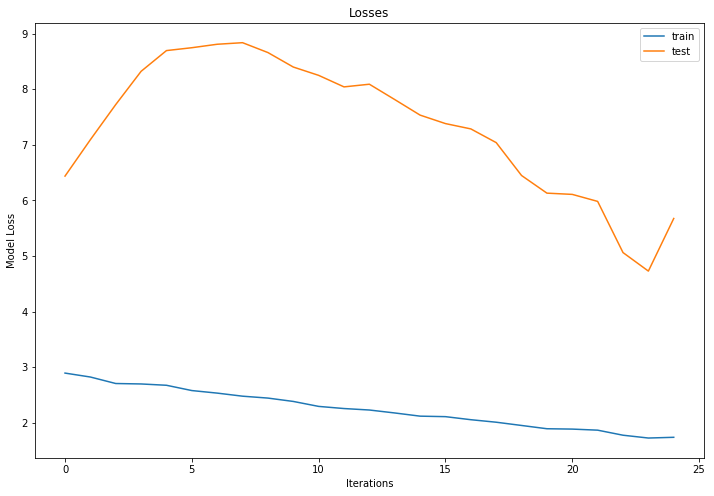

In [170]:
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_title('Losses')
axes.set_ylabel('Model Loss')
axes.set_xlabel('Iterations')
axes.legend(['train', 'test'])

In [171]:
def calculate_accuracy(X, y, model):
    AL = model.predict(X)
     
    ALVals = AL.argmax(axis=1) - 4
    yVals = y.argmax(axis=1) - 4
    
    accurate = np.sum(yVals == ALVals)
    accuracy = accurate/yVals.shape[0]
    print("Accuracy: " + str(accuracy))
    print("Accuracy if all zero predicted:" + str(np.sum(yVals == 0)/yVals.shape[0]))
    
    print("\nValues and their occurance:")
    
    for i in range(-4,5):
        print("Number: " + str(i))
        print("Occurance in Data:" +  str(np.sum(yVals == i)))
        print("Occurance in Prediction:" +  str(np.sum(ALVals == i)))
        print()

calculate_accuracy(Xtrain, ytrain, model)

Accuracy: 0.708
Accuracy if all zero predicted:0.746

Values and their occurance:
Number: -4
Occurance in Data:5
Occurance in Prediction:5

Number: -3
Occurance in Data:20
Occurance in Prediction:0

Number: -2
Occurance in Data:62
Occurance in Prediction:1

Number: -1
Occurance in Data:73
Occurance in Prediction:33

Number: 0
Occurance in Data:1119
Occurance in Prediction:1356

Number: 1
Occurance in Data:101
Occurance in Prediction:0

Number: 2
Occurance in Data:89
Occurance in Prediction:87

Number: 3
Occurance in Data:24
Occurance in Prediction:18

Number: 4
Occurance in Data:7
Occurance in Prediction:0



In [194]:
pd_Combined = pd_Xtrain.append(pd_Xtest)

In [196]:
sharpeTest = pd_Combined['Weighted Price'].pct_change()

In [236]:
def sharpe_ratio(returns, N=365):
    return np.sqrt(N) * returns.mean() / returns.std()

def sortino_ratio(returns, N=365):
    return np.sqrt(N) * returns.mean() / returns[returns < 0].std() #but we short too. so fall is not bad either

In [239]:
for i in range(1, math.ceil(pd_Combined.shape[0] / 365) + 1):
    print("From {} to next".format(sharpeTest.index[365 * (i-1)].date()))
    print("Sharpe Ratio: {}\nSortino Ratio:{}\n".format(sharpe_ratio(sharpeTest[365 * (i-1):365 * i]), sortino_ratio(sharpeTest[365 * (i-1):365 * i])))

From 2013-03-31 to next
Sharpe Ratio: 1.8697884867469279
Sortino Ratio:2.293532984312453

From 2014-03-31 to next
Sharpe Ratio: -0.6576356475741287
Sortino Ratio:-0.9144037475024734

From 2015-03-31 to next
Sharpe Ratio: 1.3772534330020059
Sortino Ratio:1.8539348433607257

From 2016-03-30 to next
Sharpe Ratio: 2.986673434072341
Sortino Ratio:4.770407079202713

From 2017-07-15 to next
Sharpe Ratio: 3.5340572118395643
Sortino Ratio:5.6851309283582045

